In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime 
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

In [10]:
data = pd.read_csv("data.csv")
data.Province_State.fillna("None", inplace=True)
display(data.head(5))
display(data.describe())
print("from", min(data['Date']), "to", max(data['Date']))


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,None,Afghanistan,2020-01-22,0.0,0.0
1,2,None,Afghanistan,2020-01-23,0.0,0.0
2,3,None,Afghanistan,2020-01-24,0.0,0.0
3,4,None,Afghanistan,2020-01-25,0.0,0.0
4,5,None,Afghanistan,2020-01-26,0.0,0.0


,Id,ConfirmedCases,Fatalities
count,31300.000000,31300.000000,31300.000000
mean,17834.500000,2352.257987,149.295304
std,10300.658578,13975.949676,1326.507243
min,1.000000,0.000000,0.000000
25%,8917.750000,0.000000,0.000000
50%,17834.500000,8.000000,0.000000
75%,26751.250000,288.000000,3.000000
max,35668.000000,304372.000000,27967.000000


from 2020-01-22 to 2020-04-30


In [11]:
#Algeria df from 2/25/2020 to 24/04/2020.

population = float(42000000)
algeria_df = pd.DataFrame()
algeria_df['ConfirmedCases'] = data.loc[data['Country_Region']=='Algeria'].ConfirmedCases.diff().fillna(0)
algeria_df = algeria_df[34:94] 
algeria_df['date'] = pd.date_range(start='2/25/2020', periods=len(algeria_df), freq='D')
algeria_df


,ConfirmedCases,date
234,1.0,2020-02-25
235,0.0,2020-02-26
236,0.0,2020-02-27
237,0.0,2020-02-28
238,0.0,2020-02-29
239,0.0,2020-03-01
240,2.0,2020-03-02
241,2.0,2020-03-03
242,7.0,2020-03-04
243,0.0,2020-03-05


In [12]:
import datetime as dt

x = algeria_df[['date']]
x = np.array(x['date'].map(dt.datetime.toordinal), dtype=float) #transform data to a numpy array of floats 
x_scale = x - x[0] 
y = algeria_df[['ConfirmedCases']]
y = np.array(y['ConfirmedCases'], dtype=float) 


In [13]:
t = np.arange(460)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / (N)
    dIdt = beta * S * I / (N) - gamma * I
    dRdt = gamma * I 
    return dSdt, dIdt, dRdt




In [14]:
from scipy.integrate import odeint as ode
from scipy.stats import poisson
from scipy.stats import norm

def model(ini, time_step, params):
	Y = np.zeros(3) #column vector for the state variables
	X = ini
	beta = params[0]
	gamma = params[1]

	Y[0] = - beta*X[0]*X[1]  #S
	Y[1] = beta*X[0]*X[1] - gamma*X[1] #I
	Y[2] = gamma*X[1] #R

	return Y

def x0fcn(params, data):
	S0 = 1.0 - (data[0]/params[2])
	I0 = data[0]/params[2]
	R0 = 0.0
	X0 = [S0, I0, R0]

	return X0

def yfcn(res, params):
	return res[:,1]*params[2]



def NLL(params, data, times): #negative log likelihood
	params = np.abs(params)
	data = np.array(data)
	res = ode(model, x0fcn(params,data), times, args=(params,))
	y = yfcn(res, params)
	nll = sum(y) - sum(data*np.log(y))
	
	# nll = -sum(np.log(poisson.pmf(np.round(data),np.round(y)))) 
	
	# ML using normally distributed measurement error (least squares)
	# nll = -sum(np.log(norm.pdf(data,y,0.1*np.mean(data)))) # example WLS assuming sigma = 0.1*mean(data)
	# nll = sum((y - data)**2)  # OLS
	return nll



#### Set initial parameter values and initial states of the optimal model ####
params = [0.3, 0.1, 3127.0]#the params and inition states are float
paramnames = ['beta', 'gamma', 'N']

optimizer = optimize.minimize(NLL, params, args=(y, x_scale), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = x0fcn(paramests, y)
paramests


array([1.80060513e-01, 3.28793164e-02, 2.09873179e+02])

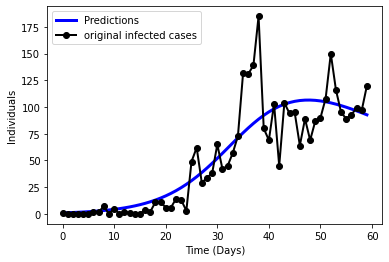

In [15]:
xest = ode(model, iniests, x_scale, args=(paramests,))
est_measure = yfcn(xest, paramests)
plt.plot(x_scale, est_measure, 'b-', linewidth=3, label='Predictions')
plt.plot(x_scale, y, 'k-o', linewidth=2, label='original infected cases')
#plt.title("Fit of the SIR model for Algeria infected cases with COVID-19")
plt.xlabel('Time (Days)')
plt.ylabel('Individuals')
plt.legend()
plt.savefig('SIR.png')
plt.show()

In [16]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error,mean_absolute_error
MAE =mean_absolute_error(y,est_measure)
int(MAE)

14

In [ ]:
est_measure


array([  1.        ,   1.15747682,   1.33951642,   1.54986454,
         1.79281609,   2.07328387,   2.39686723,   2.76994063,
         3.19972848,   3.69440354,   4.26316975,   4.9163336 ,
         5.6653772 ,   6.52300698,   7.50317049,   8.62103742,
         9.89290192,  11.33603685,  12.96842741,  14.80839635,
        16.87407626,  19.18273779,  21.74993557,  24.58849103,
        27.70732588,  31.11019044,  34.79435594,  38.74937839,
        42.95605863,  47.38573551,  52.0000623 ,  56.75138409,
        61.58378739,  66.43482407,  71.23782798,  75.92466025,
        80.42865446,  84.68749919,  88.6458013 ,  92.2571178 ,
        95.4853171 ,  98.30521723, 100.70253261, 102.673228  ,
       104.22242107, 105.36299185, 106.11405201, 106.49939886,
       106.54606613, 106.28303812, 105.74011703, 104.94705956,
       103.93285683, 102.72523576, 101.35029972,  99.83230967,
        98.19357033,  96.45439851,  94.63315115,  92.74630084])

In [17]:
#beta = copy.deepcopy(popt)
#print("beta: " + str(beta) + "\ngamma: "+ str(gamma))
beta,gamma,N =paramests[0],paramests[1],paramests[2]
beta,gamma,N
I0,R0 = y[0], 0
S0 = N - I0 - R0
y0=S0,I0,R0


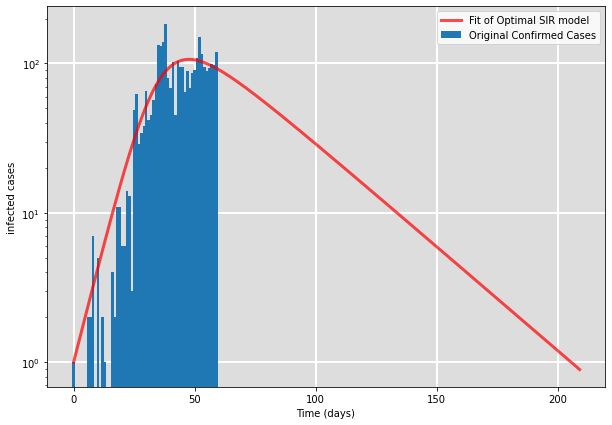

PEAK OF INFECTED CASES: 106.54607029880273
PEAK DATE : 2020-04-13 00:00:00
END DATE: 2020-09-18 00:00:00


In [18]:
from scipy.integrate import odeint
from datetime import datetime, timedelta


# Integrate the SIR equations over the time grid, t. 
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

t_plot = np.arange(210)

fig = plt.figure(facecolor='w', figsize=(10, 7))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#ax.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
ax.bar(x_scale ,y,width=1,align='center',label="Original Confirmed Cases")

#ax.plot(t_plot, S[:len(t_plot)], 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_plot, I[:len(t_plot)], 'r', alpha=0.7, lw=3, label='Fit of Optimal SIR model')
#ax.plot(t_plot, Io[:len(t_plot)], 'y', alpha=0.7, lw=3, label='Fit of SIR model in a worst-case scenario')

#ax.plot(t_plot, R[:len(t_plot)], 'g', alpha=0.5, lw=2, label='Recovered')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
plt.xlabel('Time (days)')
plt.ylabel('infected cases')
ax.set_yscale('log')
#ax.title.set_text('Prediction of the epidemic peak of COVID-19 in Algeria')
plt.legend()
plt.savefig('optimal SIR.png')
plt.show()

peak = int(t[np.where(I == max(I))[0][0]])
peak_date = country_df['date'][234] + timedelta(days=peak)

I_drop = I[t[np.where(I == max(I))[0][0]]:] 
end = int(t[np.where(I == I_drop[I_drop < 1][0])])
end_date = country_df['date'][234] + timedelta(days=end)
print("PEAK OF INFECTED CASES: " + str(max(I)) + "\nPEAK DATE : " + str(peak_date) + "\nEND DATE: " + str(end_date))

In [19]:
#### Set initial parameter values and initial states of the model in worst-case scenario ####
params = [0.95, 0.75, 43812700.0]
paramnames = ['beta', 'gamma', 'N']# N is the real population size

optimizer = optimize.minimize(NLL, params, args=(y, x_scale), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = x0fcn(paramests, y)
paramests


array([8.90985281e-01, 7.98473875e-01, 4.37923173e+07])

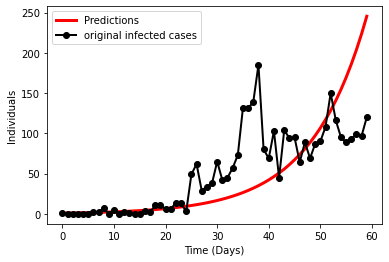

In [20]:
xest = ode(model, iniests, x_scale, args=(paramests,))
est_measure = yfcn(xest, paramests)
plt.plot(x_scale, est_measure, 'r-', linewidth=3, label='Predictions')
plt.plot(x_scale, y, 'k-o', linewidth=2, label='original infected cases')
#plt.title("Fit of the SIR model for Algeria infected cases with COVID-19")
plt.xlabel('Time (Days)')
plt.ylabel('Individuals')
plt.legend()
plt.savefig('SIRw.png')
plt.show()

In [21]:
MAE =mean_absolute_error(y,est_measure)
int(MAE)

30

In [22]:
beta,gamma,N =paramests[0],paramests[1],paramests[2]
beta,gamma,N
Io_0,R0 = y[0], 0
S0 = N - Io_0 - R0
y0=S0,Io_0,R0

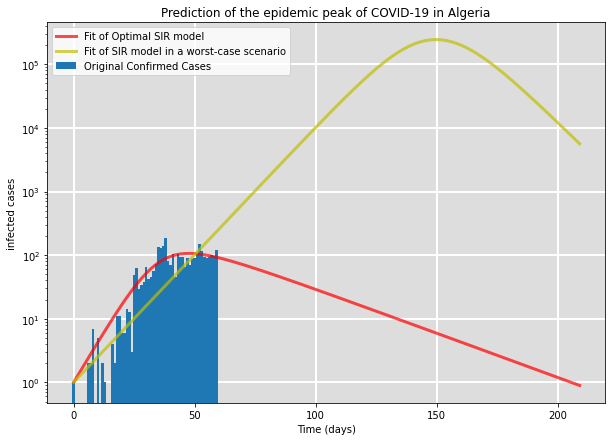

PEAK OF INFECTED CASES: 244625.08087333376
PEAK DATE : 2020-07-24 00:00:00
END DATE: 2020-11-16 00:00:00


In [29]:
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, Io, R = ret.T

t_plot = np.arange(210)

fig = plt.figure(facecolor='w', figsize=(10, 7))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#ax.plot(x_scale, y, 'ko', label="Original Confirmed Cases")
ax.bar(x_scale ,y,width=1,align='center',label="Original Confirmed Cases")

#ax.plot(t_plot, S[:len(t_plot)], 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_plot, I[:len(t_plot)], 'r', alpha=0.7, lw=3, label='Fit of Optimal SIR model')
ax.plot(t_plot, Io[:len(t_plot)], 'y', alpha=0.7, lw=3, label='Fit of SIR model in a worst-case scenario')

#ax.plot(t_plot, R[:len(t_plot)], 'g', alpha=0.5, lw=2, label='Recovered')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
plt.xlabel('Time (days)')
plt.ylabel('infected cases')
ax.set_yscale('log')
ax.title.set_text('Prediction of the epidemic peak of COVID-19 in Algeria')
plt.legend()
plt.savefig('optimal VS worst-case scenario SIR.png')
plt.show()

peak = int(t[np.where(Io == max(Io))[0][0]])
peak_date = country_df['date'][234] + timedelta(days=peak)

I_drop = Io[t[np.where(Io == max(Io))[0][0]]:] 
end = int(t[np.where(Io == I_drop[I_drop < 50][0])])
end_date = country_df['date'][234] + timedelta(days=end)
print("PEAK OF INFECTED CASES: " + str(max(Io)) + "\nPEAK DATE : " + str(peak_date) + "\nEND DATE: " + str(end_date))